# Importing Packages

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import numpy as np
import glob
import shutil
import matplotlib.pyplot as plt

In [0]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


# Data Loading

After downloading the dataset, we need to extract its contents.

In [0]:
_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

zip_file = tf.keras.utils.get_file(origin=_URL,
                                   fname="flower_photos.tgz",
                                   extract=True)

base_dir = os.path.join(os.path.dirname(zip_file), 'flower_photos')

228818944/228813984 [==============================] - 5s 0us/step


The dataset we downloaded contains images of 5 types of flowers:

1. Rose
2. Daisy
3. Dandelion
4. Sunflowers
5. Tulips

So, let's create the labels for these 5 classes: 

In [0]:
classes = ['roses', 'daisy', 'dandelion', 'sunflowers', 'tulips']

In [0]:
for cl in classes:
  img_path = os.path.join(base_dir, cl)
  images = glob.glob(img_path + '/*.jpg')
  print("{}: {} Images".format(cl, len(images)))
  train, val = images[:round(len(images)*0.8)], images[round(len(images)*0.8):]

  for t in train:
    if not os.path.exists(os.path.join(base_dir, 'train', cl)):
      os.makedirs(os.path.join(base_dir, 'train', cl))
    shutil.move(t, os.path.join(base_dir, 'train', cl))

  for v in val:
    if not os.path.exists(os.path.join(base_dir, 'val', cl)):
      os.makedirs(os.path.join(base_dir, 'val', cl))
    shutil.move(v, os.path.join(base_dir, 'val', cl))

roses: 641 Images
daisy: 633 Images
dandelion: 898 Images
sunflowers: 699 Images
tulips: 799 Images


For convenience, let us set up the path for the training and validation sets

In [0]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

# Data Augmentation



### Set Batch and Image Size

In the cell below, create a `batch_size` of 100 images and set a value to `IMG_SHAPE` such that our training data consists of images with width of 150 pixels and height of 150 pixels.

In [0]:
batch_size = 110
IMG_SHAPE = 252


In [0]:
image_gen = ImageDataGenerator(horizontal_flip=True,rescale=1/255)



In [0]:
train_data_gen = image_gen.flow_from_directory(train_dir,
                                              batch_size = batch_size,shuffle=True, target_size=(IMG_SHAPE, IMG_SHAPE),)

Found 2935 images belonging to 5 classes.


Let's take 1 sample image from our training examples and repeat it 5 times so that the augmentation can be applied to the same image 5 times over randomly, to see the augmentation in action.

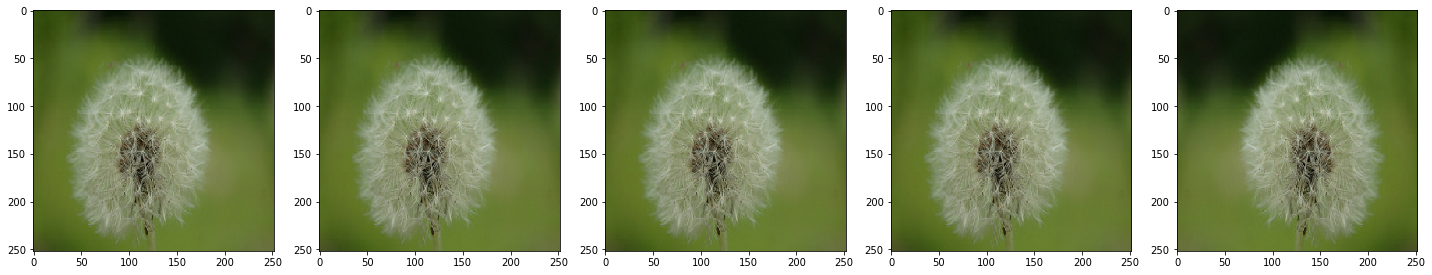

In [0]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()


augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [0]:

      
image_gen_train = ImageDataGenerator(rotation_range=360,
                                     zoom_range=0.68, 
                                     horizontal_flip=True, 
                                     width_shift_range=0.15, 
                                     height_shift_range=0.15,
                                     rescale=1./255,
                                     fill_mode='reflect',
                                     featurewise_std_normalization=False,
                                     featurewise_center=False)

train_data_gen = image_gen_train.flow_from_directory(train_dir,
                                                    shuffle=True,
                                                    batch_size=batch_size,
                                                    target_size=(IMG_SHAPE,IMG_SHAPE), class_mode='sparse')

Found 2935 images belonging to 5 classes.


Let's visualize how a single image would look like 5 different times, when we pass these augmentations randomly to our dataset. 

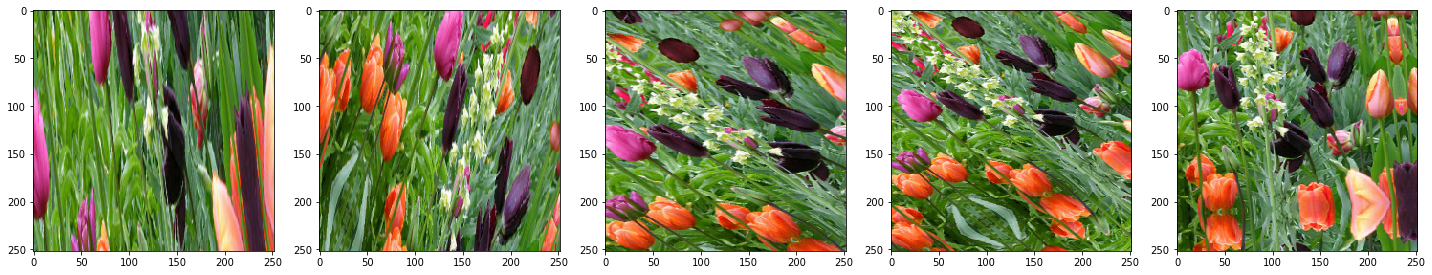

In [0]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Create a Data Generator for the Validation Set

Generally, we only apply data augmentation to our training examples. So, in the cell below, use ImageDataGenerator to create a transformation that only rescales the images by 255. Then use the `.flow_from_directory` method to apply the above transformation to the images in our validation set. Make sure you indicate the batch size, the path to the directory of the validation images, the target size for the images, and to set the class mode to `sparse`.

In [0]:
image_gen_val = ImageDataGenerator(rescale=1/255)
val_data_gen = image_gen_val.flow_from_directory(val_dir,
                                                shuffle=True,
                                                batch_size=batch_size,
                                                target_size=(IMG_SHAPE,IMG_SHAPE), class_mode='sparse')

Found 735 images belonging to 5 classes.


#  Create the CNN



In [0]:
model = tf.keras.Sequential([tf.keras.layers.Conv2D(32,(3,3), activation='relu', input_shape=(IMG_SHAPE,IMG_SHAPE, 3)),
                            tf.keras.layers.MaxPooling2D((2,2)),
                           tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
                           tf.keras.layers.MaxPooling2D((2,2)),
                           tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
                           tf.keras.layers.MaxPooling2D((2,2)),
                           tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
                           tf.keras.layers.MaxPooling2D((2,2)),
                           tf.keras.layers.Flatten(),
                           tf.keras.layers.Dropout(0.3),
                           tf.keras.layers.Dense(512, activation='relu'),
                           tf.keras.layers.Dropout(0.3),
                           tf.keras.layers.Dense(512, activation= 'relu'),
                           tf.keras.layers.Dropout(0.3),
                           tf.keras.layers.Dense(5, activation='softmax')])

W0827 11:58:26.743529 139987882841984 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


# Compile the Model

In the cell below, compiling the model using the ADAM optimizer, the sparse cross entropy function as a loss function. We would also like to look at training and validation accuracy on each epoch as we train our network.

In [0]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the Model

In the cell below, train the model using the **fit_generator** function instead of the usual **fit** function. We have to use the `fit_generator` function because we are using the **ImageDataGenerator** class to generate batches of training and validation data for the model. 

In [0]:
epochs = 200

history = model.fit_generator(train_data_gen, epochs=epochs, validation_data=val_data_gen, shuffle=True, steps_per_epoch=29, validation_steps=20) 

Epoch 1/200
29/29 [==============================] - 52s 2s/step - loss: 1.4741 - acc: 0.3246 - val_loss: 1.3190 - val_acc: 0.4606
Epoch 2/200
29/29 [==============================] - 46s 2s/step - loss: 1.2245 - acc: 0.4640 - val_loss: 1.1101 - val_acc: 0.5108
Epoch 3/200
29/29 [==============================] - 46s 2s/step - loss: 1.0563 - acc: 0.5569 - val_loss: 1.0267 - val_acc: 0.5892
Epoch 4/200
29/29 [==============================] - 46s 2s/step - loss: 1.0288 - acc: 0.5911 - val_loss: 0.9370 - val_acc: 0.6254
Epoch 5/200
29/29 [==============================] - 45s 2s/step - loss: 0.9497 - acc: 0.6138 - val_loss: 0.9619 - val_acc: 0.6399
Epoch 6/200
29/29 [==============================] - 46s 2s/step - loss: 0.9150 - acc: 0.6418 - val_loss: 0.9137 - val_acc: 0.6437
Epoch 7/200
29/29 [==============================] - 46s 2s/step - loss: 0.9023 - acc: 0.6450 - val_loss: 0.8398 - val_acc: 0.6723
Epoch 8/200
29/29 [==============================] - 47s 2s/step - loss: 0.8647 - a

# Plot Training and Validation Graphs.

In the cell below, plot the training and validation accuracy/loss graphs.

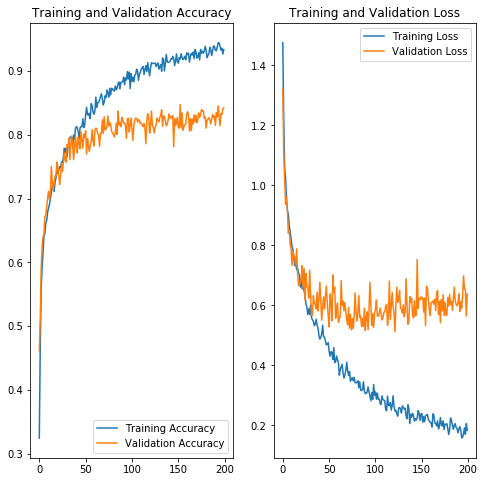

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

